In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn

plt.rcParams.update({'font.family':'cmr10', 'font.size': 12})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.formatter.use_mathtext'] = True

%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# load in training and testing dataframes

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# quick test to see if any tweets have location data or keywords

print(train_df["keyword"].shape[0]==train_df["keyword"].isna().shape[0])
print(train_df["location"].shape[0]==train_df["location"].isna().shape[0])

True
True


It looks like our dataset only contains the text and corresponding label, let's peel those out and try a supervised and unsupervised approach to see how they compare! 

### But first, let's do some EDA to see if there's any interesting patterns we can find. 

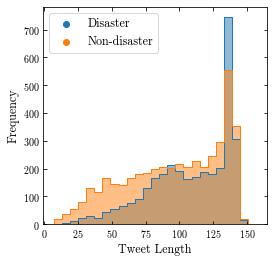

In [4]:
# do tweets about disasters tend to be longer than tweets that arent?

fig, ax = plt.subplots(1,1,figsize=(4,4))

bins = np.linspace(min(train_df["text"].str.len()), max(train_df["text"].str.len()), 26)

ax.scatter([],[],color='tab:blue',label='Disaster')
ax.scatter([],[],color='tab:orange', label='Non-disaster')

ax.hist(train_df[train_df["target"]==1]["text"].str.len(), bins=bins, histtype='stepfilled', density=False,
        color='tab:blue',alpha=0.5)
ax.hist(train_df[train_df["target"]==0]["text"].str.len(), bins=bins, histtype='stepfilled', density=False, 
        color="tab:orange",alpha=0.5)

ax.hist(train_df[train_df["target"]==1]["text"].str.len(), bins=bins, histtype='step', density=False, 
        color='tab:blue')
ax.hist(train_df[train_df["target"]==0]["text"].str.len(), bins=bins, histtype='step', density=False, 
        color="tab:orange")

ax.legend(loc='upper left', fontsize='large')

ax.set_xlabel('Tweet Length')
ax.set_ylabel('Frequency');

Looks like there may be some small correlation between tweet length and whether or not it's about a disaster, but obviously the content of the tweet will matter much more. 

People tend to use hashtags to increase the reach of their post, which would be useful to let people know about natural disasters. Is there a correlation between the presence of/number of hashtags in a post, the length of a post, and whether or not the tweet is a bout a disaster?

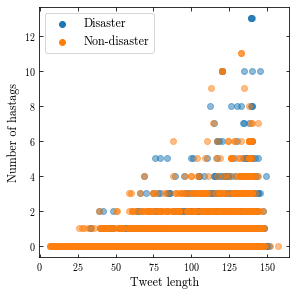

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)

ax.scatter(train_df[train_df["target"]==1]["text"].str.len(),
           train_df[train_df["target"]==1]["text"].str.count('\\#'),
           color='tab:blue', alpha=0.5)

ax.scatter(train_df[train_df["target"]==0]["text"].str.len(),
           train_df[train_df["target"]==0]["text"].str.count('\\#'),
           color='tab:orange', alpha=0.5)

ax.scatter([], [], color='tab:blue', label='Disaster')
ax.scatter([], [], color='tab:orange', label='Non-disaster')


ax.set_xlabel('Tweet length')
ax.set_ylabel('Number of hastags')
ax.legend(loc='upper left', fontsize='large');

It looks like the number of hashtags a post contains is not a good discriminant of whether or not a tweet is about a disaster. 

To get a better sense of the data, let's look at a wordcloud for the training set, separated by classes, using `NLTK` and `wordcloud`. 

In [6]:
import nltk
import re
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')
import string
import contractions
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [7]:
# let's clean the data; make all text lowercase, remove stopwords, etc. 

def clean(tweet):
    tweet = tweet.lower()
    tweet = re.sub('[^a-z A-Z 0-9-]+', '', tweet)
    tweet = " ".join([word for word in tweet.split() if word not in stopwords.words('english')])
    
    return tweet
    
train_df["cleaned"] = train_df["text"].apply(clean)
train_df.head()

,id,keyword,location,text,target,cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [8]:
# tokenize the text so we can get a frequency count

def token(text):
    tokenized = text.split()
    return tokenized

train_df["tokenized"] = train_df["cleaned"].apply(token)
train_df.head()

,id,keyword,location,text,target,cleaned,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [9]:
train_df["no_punc"] = train_df["tokenized"].apply(lambda x: [word for word in x if word not in string.punctuation])
train_df.head()

,id,keyword,location,text,target,cleaned,tokenized,no_punc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


`NLTK`, `contractions` and `string` provide a lot of powerful preprocessing tools. Let's make use of them to try and tease out the truly relevant parts of our dataset!

Now that we have our cleaned and tokenized text, we can make a frequency distribution for all of our data, as well as each class

In [10]:
# start by putting all of our tokenized data into a single string

allwords = []

for i in range(train_df.shape[0]):
    allwords += train_df["no_punc"][i]
    
print(len(allwords))
#print(allwords)

75707


In [11]:
# lets get a count of the 20 most frequent words neglecting tweet class

from collections import Counter

most_freq = Counter(allwords).most_common(20)
print(most_freq)

[('like', 344), ('im', 302), ('amp', 298), ('fire', 249), ('get', 228), ('new', 226), ('via', 220), ('dont', 206), ('people', 196), ('one', 191), ('news', 187), ('video', 164), ('us', 161), ('2', 158), ('emergency', 156), ('disaster', 151), ('police', 140), ('would', 129), ('still', 128), ('body', 125)]


In [12]:
# let's now break the word frequency down by class to see if what words appear most commonly in disaster tweets
allwords_dis = []
allwords_no_dis = []

for i in range(train_df.shape[0]):
    if train_df["target"][i] == 1:
        allwords_dis += train_df["no_punc"][i]
    elif train_df["target"][i] == 0:
        allwords_no_dis += train_df["no_punc"][i]
    else:
        print("Something went wrong")
    
print(len(allwords_dis), len(allwords_no_dis))

# check that we haven't missed/double counted any words

len(allwords_dis)+len(allwords_no_dis) == len(allwords)

34647 41060


True

In [13]:
all_words = []
all_freq = []
for word, freq in most_freq:
    all_words.append(word)
    all_freq.append(freq)

dis_words = []
dis_freq = []
for word, freq in Counter(allwords_dis).most_common(20):
    dis_words.append(word)
    dis_freq.append(freq)

no_dis_words = []
no_dis_freq = []
for word, freq in Counter(allwords_no_dis).most_common(20):
    no_dis_words.append(word)
    no_dis_freq.append(freq)

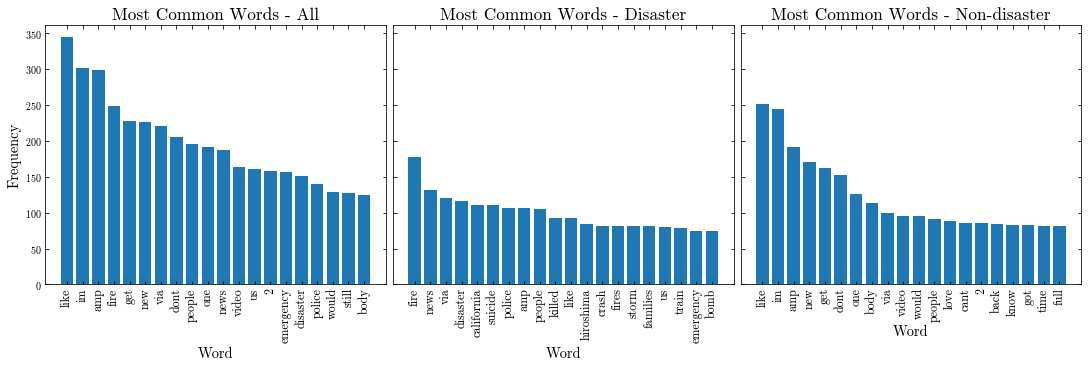

In [14]:
# make bar charts of word frequency by class

fig, ax = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, sharey=True)

ax[0].bar(all_words, all_freq)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].set_ylabel('Frequency', fontsize='x-large')
ax[0].set_xlabel('Word', fontsize='x-large')
ax[0].set_title('Most Common Words - All', fontsize='xx-large')

ax[1].bar(dis_words, dis_freq)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].set_xlabel('Word', fontsize='x-large')
ax[1].set_title('Most Common Words - Disaster', fontsize='xx-large')

ax[2].bar(no_dis_words, no_dis_freq)
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].xaxis.set_tick_params(labelsize=12)
ax[2].set_xlabel('Word', fontsize='x-large')
ax[2].set_title('Most Common Words - Non-disaster', fontsize='xx-large');

We can see a very clear separation between the most commonly used words in disaster tweets vs those not about disasters. By adding words to our list of `stopwords`, such as 'like', 'im', 'amp', etc., we would likely see an even greater visual separation between the words most commonly used in out two classes. 

As we would have naïvely expected, words directly associated with disasters, like 'fire', 'emergency', and 'disaster' show up more frequently in tweets about disasters. Somewhat surprising, though, is that words like 'news', 'breaking', and 'via' also show up more frequently in tweets about disasters. With hindsight, this makes sense, as disasters are likely to be news-worthy events. 

With our EDA done, let's shift our attention to building a model that can reliably classify a tweet as being about a disaster or not. 

# Constructing a Supervised Classifier

In [106]:
# Let's use an LSTM model with a few dropout layers to avoid overfitting

#max_len = max(max(train_df["no_punc"].str.len()),max(test_df["no_punc"].str.len()))
max_len = max(train_df["no_punc"].str.len())
print(max_len)

# start by tokenizing the text
max_features = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features,char_level=True,lower=True)
tokenizer.fit_on_texts(train_df["no_punc"].values)

# convert text to sequences

train_sequences = tokenizer.texts_to_sequences(train_df["no_punc"].values)
#test_sequences = tokenizer.texts_to_sequences(test_df["no_"].values)

print(len(train_sequences))
#print(len(test_sequences))

25
7613


In [107]:
# start by preprocessing our text data to make sure every tweet is zero padded to be the same length as the longest
# tweet in our training or testing set

train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, 20)
print(train_sequences.shape)

(7613, 20)


In [116]:
# create and compile the model

es = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=10,verbose=1,min_delta=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=5,factor=0.3,verbose=1,min_delta=1e-3)

emb_dim = 32
lstm_dim = 32

classifier = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features, emb_dim, input_length=max_len),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.LSTM(lstm_dim, dropout=0.2, recurrent_dropout=0.4, return_sequences=True),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(lstm_dim, dropout=0.2, recurrent_dropout=0.4),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(loss='binary_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(2e-3),
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 25, 32)            96000     
_________________________________________________________________
dropout_32 (Dropout)         (None, 25, 32)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________


In [109]:
# create artificial training and testing data since the true test set labels are unavailable

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(train_sequences,
                                                                            np.array(train_df["target"]),
                                                                            test_size=0.2, shuffle=True)

In [ ]:
# train the model

classifier.fit(X_train, Y_train, batch_size=128, validation_data=((X_test, Y_test)), 
               callbacks=[reduce_lr, es], epochs=100, verbose=1)

Epoch 1/100


2023-07-18 11:57:47.191704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.6187WARNING:tensorflow:Model was constructed with shape (None, 25) for input KerasTensor(type_spec=TensorSpec(shape=(None, 25), dtype=tf.float32, name='embedding_22_input'), name='embedding_22_input', description="created by layer 'embedding_22_input'"), but it was called on an input with incompatible shape (None, 20).


2023-07-18 11:58:33.540026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 48s 973ms/step - loss: 0.6514 - accuracy: 0.6187 - val_loss: 0.5725 - val_accuracy: 0.7787
Epoch 2/100
48/48 [==============================] - 43s 900ms/step - loss: 0.4448 - accuracy: 0.8131 - val_loss: 0.4408 - val_accuracy: 0.8063
Epoch 3/100
48/48 [==============================] - 44s 908ms/step - loss: 0.3459 - accuracy: 0.8539 - val_loss: 0.4637 - val_accuracy: 0.7932
Epoch 4/100
48/48 [==============================] - 44s 913ms/step - loss: 0.3005 - accuracy: 0.8777 - val_loss: 0.4896 - val_accuracy: 0.7886
Epoch 5/100
48/48 [==============================] - 46s 950ms/step - loss: 0.2703 - accuracy: 0.8900 - val_loss: 0.5328 - val_accuracy: 0.7794
Epoch 6/100
48/48 [==============================] - 43s 887ms/step - loss: 0.2470 - accuracy: 0.8992 - val_loss: 0.5864 - val_accuracy: 0.7722
Epoch 7/100
48/48 [==============================] - 44s 923ms/step - loss: 0.2255 - accuracy: 0.9099 - val_loss: 0.6525 - val_accuracy: 0.7748
Epoc

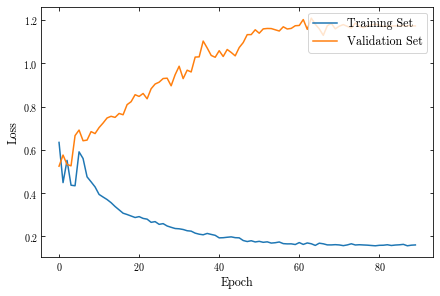

In [113]:
# Let's do a quick check to see if we're overfitting (though from the val_loss alone it looks like we are)

fig, ax = plt.subplots(1, 1, constrained_layout=True)

ax.plot(classifier.history.history['loss'], label='Training Set')
ax.plot(classifier.history.history['val_loss'], label='Validation Set')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right', fontsize='large');

2023-07-18 11:53:50.417891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-07-18 11:53:50.451751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


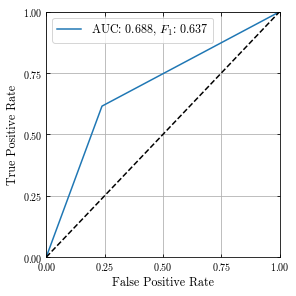

In [114]:
# compute some metrics with our test set
y_pred = classifier.predict(X_test).round()

fpr, tpr, thresh = sklearn.metrics.roc_curve(Y_test, y_pred)

auc = sklearn.metrics.roc_auc_score(Y_test, y_pred)

f1_score = sklearn.metrics.f1_score(Y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(4,4), constrained_layout=True)

ax.plot(fpr, tpr, color='tab:blue')
ax.plot([0,1],[0,1], 'k--')
ax.plot([],[], color='tab:blue', label=r'AUC: {:.3f}, $F_1$: {:.3f}'.format(auc, f1_score))
ax.legend(loc='best', fontsize='large')
ax.set_xlabel('False Positive Rate', fontsize='large')
ax.set_ylabel('True Positive Rate', fontsize='large')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
ax.set_yticks([0.00, 0.25, 0.50, 0.75, 1.00])
ax.grid();

In [115]:
print(sklearn.metrics.classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       870
           1       0.66      0.62      0.64       653

    accuracy                           0.70      1523
   macro avg       0.69      0.69      0.69      1523
weighted avg       0.70      0.70      0.70      1523

